In [1]:
# ! pip install tclab
import tclab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import winsound

# Training data
Generate 60 minutes of clean data to train a classifier to detect when the TCLab heater 1 (Q1) is on or off

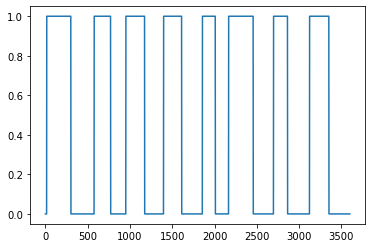

In [2]:
# Run time in minutes
run_time = 60.0

# 1 cycle per second
cycles = int(60.0*run_time)

# Time array
tm = np.array(range(cycles)).astype(float)

### Generate on/off inputs for heater 1 (Q1) ###
Q1 = np.zeros(cycles)

end = 15 # leave 1st 15 seconds of Q1 as 0
on = False
while end <= cycles:
    start = end
    end += random.randint(150,300) # keep new Q1 value for varied time
    on = not on
    if on:
        Q1[start:end] = 1
    else:
        Q1[start:end] = 0
        
plt.plot(Q1);

In [3]:
# Connect to Arduino and generate anomaly-free data
with tclab.TCLab() as lab: 

    # Print current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Temperature (C)
    T1 = np.ones(cycles) * lab.T1 # measured T (degC)

    # Run TCLab to generate training data
    start_time = time.time()

    for i in range(cycles):
        # Record time
        t = time.time()
        tm[i] = t - start_time

        # Turn on heater to 70% when Q1 is 1
        lab.Q1(Q1[i] * 70)

        # Record T1 (degC)
        T1[i] = lab.T1

        # Delay 1 second
        while time.time() < t + 1.0:
            pass

TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 33.14 °C
Temperature 2: 24.77 °C
TCLab disconnected successfully.


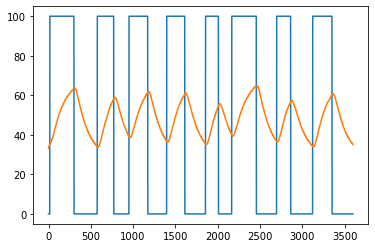

In [4]:
# Plot and save results to dataframe
plt.plot(Q1*100)
plt.plot(T1)

df = pd.DataFrame()
df['t'] = tm
df['T1'] = T1
df['Q1'] = Q1
df.to_csv('train.csv',index=False)

# Test data with anomalies
Generate 20 minutes of TCLab data that includes an anomalous event (fan blowing over the heater)

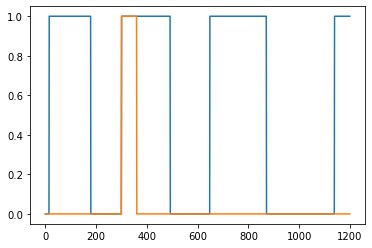

In [5]:
# Run time in minutes 
run_time = 20.0

# 1 cycle per second
cycles = int(60.0*run_time)

# Time array
tm = np.array(range(cycles)).astype(float)

### Generate on/off inputs for heater 1 (Q1) ###
Q1 = np.zeros(cycles)

end = 15 # leave 1st 15 seconds of Q1 as 0
on = False
while end <= cycles:
    start = end
    end += random.randint(150,300) # keep new Q1 value for varied time
    on = not on
    if on:
        Q1[start:end] = 1
    else:
        Q1[start:end] = 0

# Generate time for fan to turn on
fan = np.zeros(cycles)
fan_on = 300
fan_off = 360
fan[fan_on:fan_off] = 1
Q1[fan_on:fan_off] = 1

# Plot
plt.plot(Q1)
plt.plot(fan);

In [6]:
# Connect to Arduino and generate anomalous data
with tclab.TCLab() as lab: 

    # Print current T1, T2
    print('Temperature 1: {0:0.2f} °C'.format(lab.T1))
    print('Temperature 2: {0:0.2f} °C'.format(lab.T2))

    # Temperature (C)
    T1 = np.ones(cycles) * lab.T1 # measured T (degC)

    # Run TCLab to generate training data
    start_time = time.time()

    for i in range(cycles):
        # Record time
        t = time.time()
        tm[i] = t - start_time

        # Turn on heater 1 to 70% when Q1 is 1
        lab.Q1(Q1[i] * 70)
        
        # Record T1 (degC)
        T1[i] = lab.T1
        
        # Turn on fan between specified time, with warning beeps
        if i == fan_on - 10:
            print('Prepare to turn on fan')
            winsound.Beep(2500, 250)
        if i == fan_on:
            print('Turn on fan')
            winsound.Beep(2500, 250)
        if i == fan_off:
            print('Turn off fan')
            winsound.Beep(2500, 250)

        # Delay 1 second
        while time.time() < t + 1.0:
            pass


TCLab version 0.4.9
Arduino Leonardo connected on port COM3 at 115200 baud.
TCLab Firmware Version 1.01.
Temperature 1: 34.76 °C
Temperature 2: 30.82 °C
Prepare to turn on fan
Turn on fan
Turn off fan
TCLab disconnected successfully.


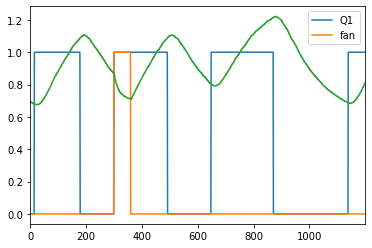

In [7]:
# Plot and save data to dataframe
df = pd.DataFrame()
df['t'] = tm
df['T1'] = T1
df['Q1'] = Q1
df['fan'] = fan
df.to_csv('test.csv',index=False)
df[['Q1','fan']].plot()
plt.plot(df['T1']/50)